**Creación del conjunto de datos:** 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
% matplotlib inline

In [3]:
os.chdir("C:/Users/Heber/Desktop/curso_geopython/Unidad IV. Análisis Estructural/GSLIB_PYTHON") # cambio del directorio de trabajo

In [4]:
# utilidad para convertir archivos GSLIB Geo-EAS en una ndarray numpy para usar con métodos Python
def GSLIB2ndarray(data_file,kcol,nx,ny):
    import os
    import numpy as np  

    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)
        
    with open(data_file) as myfile:  
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          
        for icol in range(0, ncol):   
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]
        for iy in range(0,ny):
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ny-1-iy][ix] = head[0].split()[kcol]
    return array,col_name

In [5]:
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file):
    import os
    import numpy as np 
    
    hmn = hsiz * 0.5   
    hctab = int(hrange1/hsiz)*2 + 1
    
    sim_array = np.random.rand(nx,ny)
  
    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(hrange1) + " " + str(hrange2) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write("1    0.0                      -nst, nugget effect                          \n")
    file.write("1    1.0 " + str(azi) + " 0.0 0.0 -it,cc,ang1,ang2,ang3                    \n")
    file.write(" " + str(hrange1) + " " + str(hrange2) + " 1.0 -a_hmax, a_hmin, a_vert     \n")
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array)

In [6]:
# Corrección de la distribución afín reimplementada en Python con métodos numpy
def affine(array,tmean,tstdev):    
    if array.ndim != 2:
        Print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    mean = np.average(array)
    stdev = np.std(array)
    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy]= (tstdev/stdev)*(array[ix,iy] - mean) + tmean  
    return(array)            

In [7]:
nx = 100; ny = 100; cell_size = 10 # numero de celdas y tamaño de la celda
xmin = 0; ymin=0 # origen de la grilla
xmax = xmin + nx*cell_size; ymax = ymin + ny*cell_size # calculando la extensión del modelo (grilla)

seed = 74074 # Semilla para la generación de números aleatorios para la similación estocastica. 

range_max = 500; range_min = 200; azimuth = 90 # rangos del variograma y el azimut.

mean = 10; stdev = 2 # ingresando la ley media y la desviación estandar de la variable.

vmin = 4; vmax=16; cmap = plt.cm.viridis #color min, color max, el mapa de colores (estilo) a utilizar.

sim, value =  GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,range_max,range_min,azimuth,"simulation") #realización estocastica.

sim = affine(sim, mean, stdev)



In [8]:
# utilidad para convertir matriz numpy en un archivo Geo-EAS GSLIB para usar con métodos GSLIB  
def ndarray2GSLIB(array,data_file,col_name):
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write('1 \n')  
    file_out.write(col_name  + '\n') 
    if array.ndim == 2:
        ny = (array.shape[0])
        nx = (array.shape[1])
        ncol = 1
        for iy in range(0, ny):
            for ix in range(0, nx):
                file_out.write(str(array[ny-1-iy,ix])+ '\n')        
    elif array.ndim == 1:
        nx = len(array)        
        for ix in range(0, nx):
            file_out.write(str(array[ix])+ '\n')             
    else:       
        Print("Error: must use a 2D array")            
        file_out.close()
        return            
    file_out.close()

In [9]:
# Transformación normal. 
def nscore(x):
    import os
    import numpy as np
    file = 'nscore_out.dat'
    ndarray2GSLIB(x,"nscore.dat","value")
    
    file = open("nscore.par", "w")
    file.write("                  Parameters for NSCORE                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("nscore.dat           -file with data                                       \n")
    file.write("1   0                    -  columns for variable and weight                \n")
    file.write("-1.0e21   1.0e21         -  trimming limits                                \n")
    file.write("0                        -1=transform according to specified ref. dist.    \n")
    file.write("../histsmth/histsmth.out -  file with reference dist.                      \n")
    file.write("1   2                    -  columns for variable and weight                \n")
    file.write("nscore.out               -file for output                                  \n")
    file.write("nscore.trn               -file for output transformation table             \n")
    file.close()

    os.system('nscore.exe nscore.par')
    file_in = 'nscore.out'
    y,name = GSLIB2ndarray('nscore.out',1,nx,ny)
    return(y)

In [10]:
nscore_sim = nscore(sim)

In [11]:
# histograma, reimplementado en Python de GSLIB hist con métodos MatPlotLib
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')    
    plt.show()
    return

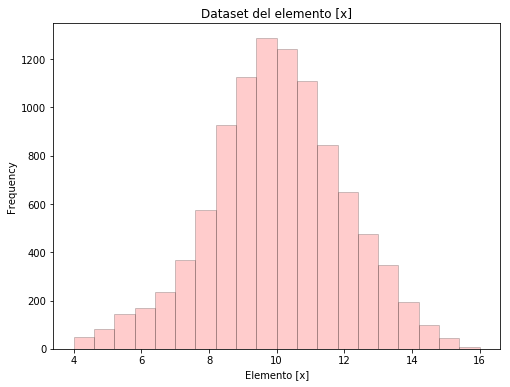

Ley media: 10.0 Varianza: 4.0


In [12]:
hist(sim.flatten(), vmin, vmax, log=False, cumul=False, bins=20, weights=None, xlabel="Elemento [x]", title="Dataset del elemento [x]")

media = np.average(sim)
varianza = np.var(sim)

print("Ley media:", round(media, 2), "Varianza:", round(varianza, 2))

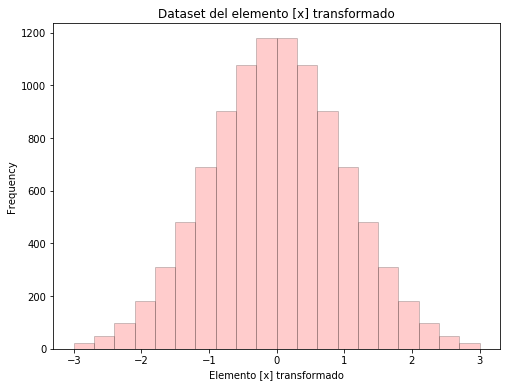

Ley media trans: -0.0 Varianza trans: 1.0


In [13]:
hist(nscore_sim.flatten(), -3, 3, log=False, cumul=False, bins=20, weights=None, xlabel="Elemento [x] transformado", title="Dataset del elemento [x] transformado")

media_t = np.average(nscore_sim)
varianza_t = np.var(nscore_sim)

print("Ley media trans:", round(media_t, 2), "Varianza trans:", round(varianza_t, 2))

In [14]:
# gráfico de píxeles, reimplementación en Python de GSLIB pixelplt con métodos MatPlotLib
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return im

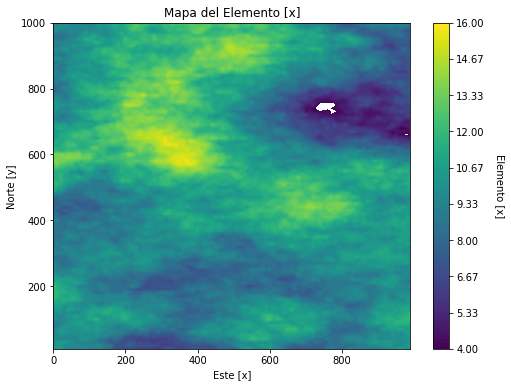

In [15]:
pixelplt(sim,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,"Mapa del Elemento [x]","Este [x]","Norte [y]","Elemento [x]",cmap)
plt.show()

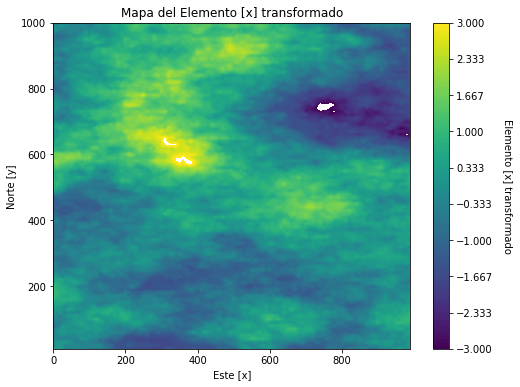

In [16]:
pixelplt(nscore_sim,xmin,xmax,ymin,ymax,cell_size,-3,3,"Mapa del Elemento [x] transformado","Este [x]","Norte [y]","Elemento [x] transformado",cmap)
plt.show()

**Funciones para el mapa variográfico:**

In [62]:
# regular spaced data, 2D wrapper for varmap from GSLIB (.exe must be in working directory)
def varmap_2d(array,nx,ny,hsiz,nlagx,nlagy,minpairs,vmax,bstand,title,vlabel):
    import os
    import numpy as np
     
    ndarray2GSLIB(array,"varmap_out.dat","gam.dat")
    
    file = open("varmap.par", "w")
    
    file.write("              Parameters for VARMAP                                        \n")
    file.write("              *********************                                        \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("varmap_out.dat          -file with data                                    \n")
    file.write("1   1                        -   number of variables: column numbers       \n")
    file.write("-1.0e21     1.0e21           -   trimming limits                           \n")
    file.write("1                            -1=regular grid, 0=scattered values           \n")
    file.write(str(nx) + " " + str(ny) + " 1  -if =1: nx,     ny,   nz                     \n")
    file.write(str(hsiz) + " " + str(hsiz) + " 1.0  - xsiz, ysiz, zsiz                     \n") 
    file.write("1   2   0                    -if =0: columns for x,y, z coordinates        \n") 
    file.write("varmap.out                   -file for variogram output                    \n")
    file.write(str(nlagx) + " " + str(nlagy) + " 0 " + "-nxlag, nylag, nzlag               \n")
    file.write(str(hsiz) + " " + str(hsiz) + " 1.0              -dxlag, dylag, dzlag       \n")
    file.write(str(minpairs) + "             -minimum number of pairs                      \n")
    file.write(str(bstand) + "               -standardize sill? (0=no, 1=yes)              \n")
    file.write("1                            -number of variograms                         \n") 
    file.write("1   1   1                    -tail, head, variogram type                   \n")
    file.close()
    
    os.system('varmap.exe varmap.par')
    nnx = nlagx*2+1; nny = nlagy*2+1
    varmap, name = GSLIB2ndarray("varmap.out",0,nnx,nny)               
          
    xmax = ((float(nlagx)+0.5)*hsiz); xmin = -1*xmax; 
    ymax = ((float(nlagy)+0.5)*hsiz); ymin = -1*ymax; 
    pixelplt(varmap,xmin,xmax,ymin,ymax,hsiz,0,vmax,title,'X','Y',vlabel,cmap)
    return(varmap)

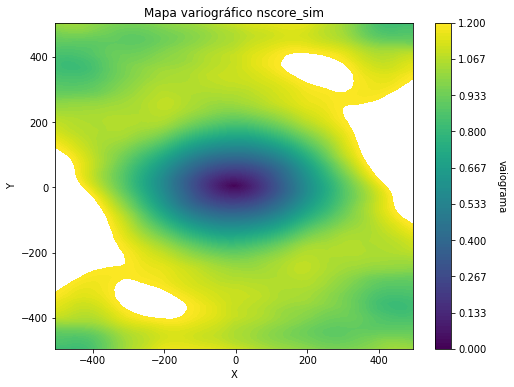

In [63]:
nlagx=50 ; nlagy=50; minpairs=5 ; vmax=1.2 ;bstand =1
varmap_regular = varmap_2d(nscore_sim,nx,ny,cell_size,nlagx,nlagy,minpairs,vmax,bstand,'Mapa variográfico nscore_sim','vaiograma')


**Ahora trabajaremos un ejemplo, pero con un set de datos repartidos en el espacio 2D de forma irregular:**

In [78]:
def random_sample(array,xmin,xmax,ymin,ymax,step,nsamp,name):
    import random as rand
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-1, ymin-1, -1*step))
    nx = xx.shape[0]
    ny = xx.shape[1]
    sample_index = rand.sample(range((nx)*(ny)), nsamp)
    for isamp in range(0,nsamp):
        iy = int(sample_index[isamp]/ny)
        ix = sample_index[isamp] - iy*nx
        x.append(xx[ix,iy])
        y.append(yy[ix,iy])
        v.append(array[ix,iy])
   
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

In [79]:
rand_sample = random_sample(nscore_sim,xmin,xmax,ymin,ymax,cell_size,100,'Elemento [x]') # El nombre rand_sample esta escrito en la función, por lo cual recomiendo mantenerlo.
type(rand_sample) # este archivo será un df de pandas.

pandas.core.frame.DataFrame

**Visualicemos la extracción de datos espaciados de forma irregular desde el modelo:**

In [80]:
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return im

In [81]:
rand_sample.head()

,X,Y,Elemento [x]
0,620.0,639.0,-0.71194
1,910.0,509.0,0.65588
2,340.0,969.0,0.91556
3,790.0,149.0,-0.86489
4,970.0,469.0,-0.18363


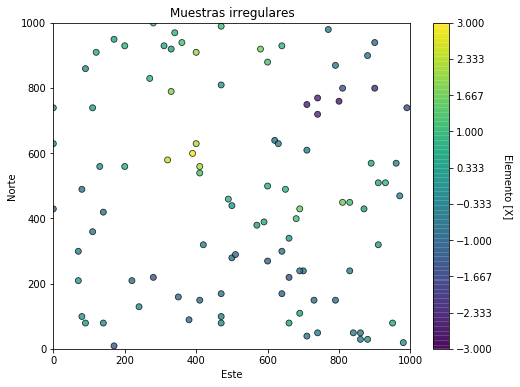

In [82]:
locmap(rand_sample,"X","Y","Elemento [x]",xmin,xmax,ymin,ymax,-3,3,"Muestras irregulares","Este","Norte","Elemento [X]",cmap)

**Ahora generaremos el mapa variográfico para estas muestras irregulares:**

In [83]:
def Dataframe2GSLIB(data_file,df):
    colArray = []
    colArray = df.columns
    ncol = len(df.columns) 
    nrow = len(df.index)
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write(str(ncol) + '\n') 
    for icol in range(0, ncol): 
        file_out.write(df.columns[icol]  + '\n')  
    
    for irow in range(0, nrow):
        for icol in range(0, ncol):
            file_out.write(str(df.iloc[irow,icol])+ ' ')  
        file_out.write('\n')

    file_out.close()

In [84]:
def varmapv_2d(df,xcol,ycol,vcol,nx,ny,lagdist,minpairs,vmax,bstand,title,vlabel):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    df_ext = pd.DataFrame({'X':df[xcol],'Y':df[ycol],'Z':rand_sample[vcol]})
    Dataframe2GSLIB("varmap_out.dat",df_ext)
    
    file = open("varmap.par", "w")
    
    file.write("              Parameters for VARMAP                                        \n")
    file.write("              *********************                                        \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("varmap_out.dat          -file with data                                    \n")
    file.write("1   3                        -   number of variables: column numbers       \n")
    file.write("-1.0e21     1.0e21           -   trimming limits                           \n")
    file.write("0                            -1=regular grid, 0=scattered values           \n")
    file.write(" 50   50    1                -if =1: nx,     ny,   nz                      \n")
    file.write("1.0  1.0  1.0                -       xsiz, ysiz, zsiz                      \n") 
    file.write("1   2   0                    -if =0: columns for x,y, z coordinates        \n") 
    file.write("varmap.out                   -file for variogram output                    \n")
    file.write(str(nx) + " " + str(ny) + " 0 " + "-nxlag, nylag, nzlag                     \n")
    file.write(str(lagdist) + " " + str(lagdist) + " 1.0              -dxlag, dylag, dzlag \n")
    file.write(str(minpairs) + "             -minimum number of pairs                      \n")
    file.write(str(bstand) + "               -standardize sill? (0=no, 1=yes)              \n")
    file.write("1                            -number of variograms                         \n") 
    file.write("1   1   1                    -tail, head, variogram type                   \n")
    file.close()
    
    os.system('varmap.exe varmap.par')
    nnx = nx*2+1; nny = ny*2+1
    varmap, name = GSLIB2ndarray("varmap.out",0,nnx,nny)               
          
    xmax = ((float(nx)+0.5)*lagdist); xmin = -1*xmax; 
    ymax = ((float(ny)+0.5)*lagdist); ymin = -1*ymax; 
    pixelplt(varmap,xmin,xmax,ymin,ymax,lagdist,0,vmax,title,'X','Y',vlabel,cmap)
    return(varmap)

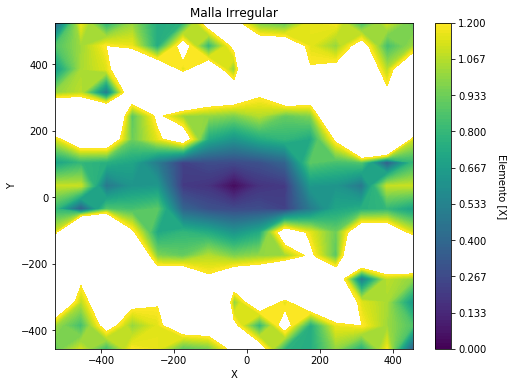

In [85]:
lagdist= 70; nlagx = 7; nlagy = 7;
varmap_irregular = varmapv_2d(rand_sample,"X","Y","Elemento [x]",nlagx,nlagy,lagdist,minpairs,vmax,bstand,"Malla Irregular","Elemento [X]")